# Aim of this project 

Write an abstract
Solubility of small organic molecules in drug desing is very important.
Solubility plays a critical role in
Experimental definition of solublity is a quite expensive procedure.
It will very valuable to have a predictive model that could estimate the solubility of drug-like molecules.
The aim of this project is to test different predictive models and chemical fingerprints in estimating the solublity of small like molecules.

----

### What is solubility? What is logP?

In [22]:
# RDKit packages
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors


# RDKit descriptors
from rdkit.Chem.EState import Fingerprinter
from rdkit.Chem.rdmolops import RDKFingerprint
from rdkit.Avalon.pyAvalonTools import GetAvalonFP
from rdkit.Avalon import pyAvalonTools
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprint, GetHashedAtomPairFingerprintAsBitVect
from rdkit.Chem.rdMolDescriptors import GetHashedTopologicalTorsionFingerprintAsBitVect
from rdkit.Chem.AtomPairs.Sheridan import GetBPFingerprint
from rdkit.Chem.EState.Fingerprinter import FingerprintMol
from rdkit.Avalon.pyAvalonTools import GetAvalonFP 
from rdkit.Chem.AllChem import  GetMorganFingerprintAsBitVect, GetErGFingerprint
from rdkit.DataStructs.cDataStructs import ConvertToNumpyArray
import rdkit.DataStructs.cDataStructs

import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import spearmanr, pearsonr

from sklearn.linear_model import Ridge, BayesianRidge, LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn import cross_validation

from xgboost import XGBClassifier
import lightgbm as lgb


from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

                 smiles  solubility  logp
0  c1ccccc1c2cc(Cl)ccc2       -4.88  4.40
1  O=N(=O)c(c(ccc1)C)c1       -2.33  2.36
2          CC(O)CCC(C)C       -1.38  2.17
The Huuskonsen data set contains  1297  compounds


,smiles,solubility,logp,ROMol,MW,HeavyAtomCount,RingCount,TPSA
0,c1ccccc1c2cc(Cl)ccc2,-4.88,4.4,,188.657,13,2,0.0

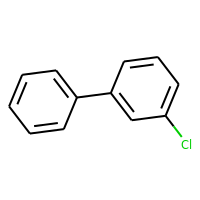

In [7]:
#Read solubility data
sol_data = pd.read_csv('datasets/huuskonsen_data.csv')
print(sol_data.head(n=3))

#Add some new descriptors (physchem properties)
sol_data['ROMol'] = sol_data['smiles'].apply(Chem.MolFromSmiles)
print("The Huuskonsen data set contains ", len(sol_data), " compounds")

# Adding a few more descriptors (MW, HAC, RingCount, and TPSA)
# Althought, in this project we will use only the structural fingerprints 
# to calculate a small molecule's logp
sol_data['MW']             = sol_data['ROMol'].map(Descriptors.MolWt)
sol_data['HeavyAtomCount'] = sol_data['ROMol'].map(Descriptors.HeavyAtomCount)
sol_data['RingCount']      = sol_data['ROMol'].map(Descriptors.RingCount)
sol_data['TPSA']           = sol_data['ROMol'].map(Descriptors.TPSA)

# Add Chemical structure to Pandas frame
PandasTools.AddMoleculeColumnToFrame(sol_data,smilesCol='smiles',molCol='ROMol',includeFingerprints=True)

# Target values
y = sol_data['solubility'].values
sol_data.head(n=1)

----
1297 small organic compounds can be found in the Huuskonsen data set.  
Let's __visualize__ the _chemical space_ of the compounds found in the training dataset!

In [9]:
sol_data.describe()

,solubility,logp,MW,HeavyAtomCount,RingCount,TPSA
count,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000
mean,-2.751434,2.443724,199.453295,13.045490,1.382421,36.640486
std,2.040823,2.036324,94.710410,6.299392,1.269393,34.777512
min,-11.620000,-8.780000,17.031000,1.000000,0.000000,0.000000
25%,-3.960000,1.280000,122.189000,8.000000,0.000000,9.230000
50%,-2.510000,2.340000,178.220000,12.000000,1.000000,29.100000
75%,-1.380000,3.590000,260.676000,17.000000,2.000000,52.930000
max,1.580000,10.200000,665.733000,47.000000,7.000000,331.940000


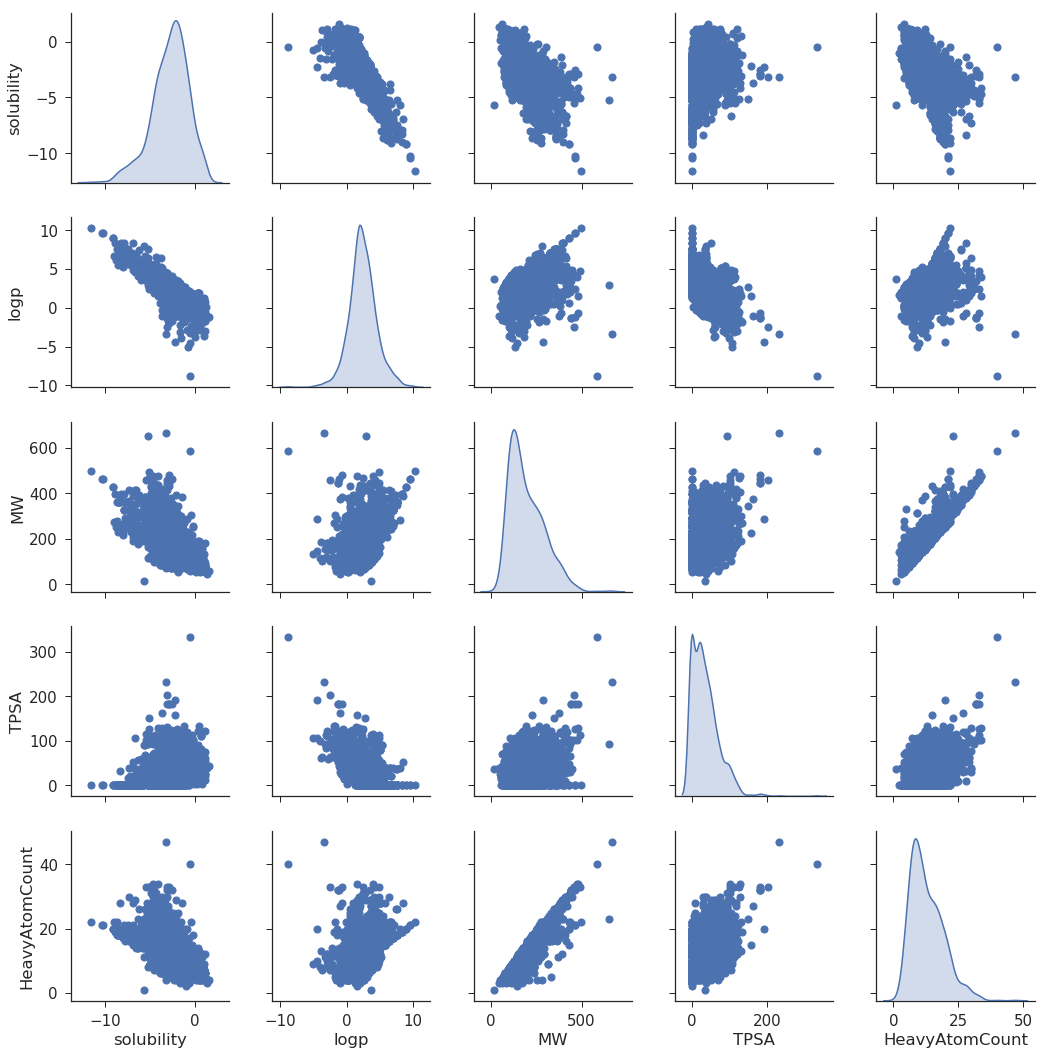

In [11]:
# seaborn -- for better looking plots
import seaborn as sns
sns.set(style="ticks", color_codes=True)
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1.5})
#sns.set_context("talk", rc={"lines.linewidth": 2})
sns.color_palette("pastel")

g = sns.pairplot(sol_data[['solubility', 'logp', 'MW', 'TPSA', 'HeavyAtomCount']], size=3, diag_kind="kde", markers="o",
                 plot_kws=dict(s=50, edgecolor="b", linewidth=1),
                 diag_kws=dict(shade=True))

### Training dataset's description

The training dataset contains 1297 organic molecules having on average two rings and MW around 200. From the average value of Polar Surface Area (TPSA) we can infer that in the training dataset there are not many compounds with heteroatoms (N,O,S,P).

----

From the plot and the data summary, displayed above, we notice that there are a few compounds with high MW (MW~600) and high Polar Surface Area (TPSA > 100).
I would like to highlight these compounds and then it will be interesting to check how the models's behaviour on these compounds.

There are 15 compounds with high MW (>550) and TPSA (>130) values!


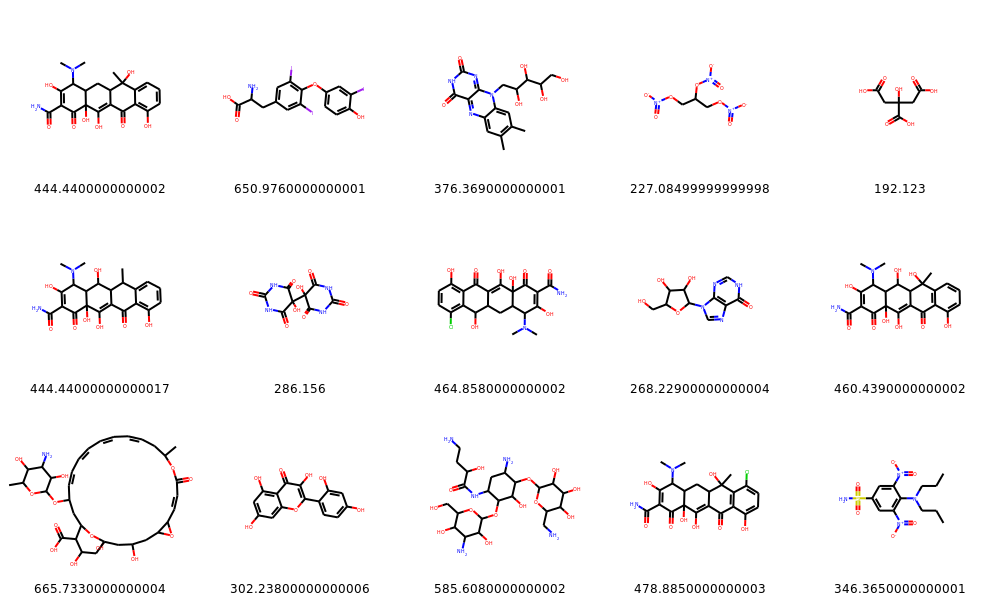

In [12]:
highMW =  sol_data[(sol_data['MW'] > 550) | (sol_data['TPSA'] > 130)]
#highMW.head()
print("There are", len(highMW), "compounds with high MW (>550) and TPSA (>130) values!")
PandasTools.FrameToGridImage(highMW,molsPerRow=5, legendsCol='MW')

There are indeed some very "interesting" compounds in this dataset.   
It would be interesting to see if the ML models could predict accurately the solubility values of these 15 compounds.

-----

### Let's make some (chemical) fingerprints!
#### Discussion about fingerprints...


In [14]:
print("Converting Estate fingerprints")

# Estate fingerprints
def estate_fingerprint(mol):
    return FingerprintMol(mol)[0]

sol_data['fp_Estate'] = sol_data['ROMol'].apply(estate_fingerprint)

print("Converting Morgan fingerprints")

# Morgan fingerprints, length 1024 bits
def Morgan_fingerprint(mol):
    fp = np.zeros((1,))
    ConvertToNumpyArray(GetMorganFingerprintAsBitVect(mol, 2, nBits = 1024), fp)
    return fp

sol_data['fp_Morgan'] = sol_data['ROMol'].apply(Morgan_fingerprint)

print("Converting RDKit fingerprints")

# RDKit fingerprints, length 1024 bits
def RDKit_fingerprint(mol):
    fp = np.zeros((1,))
    ConvertToNumpyArray(RDKFingerprint(mol, 2, fpSize = 1024), fp)
    return fp

sol_data['fp_RDKit'] = sol_data['ROMol'].apply(RDKit_fingerprint)

print("Converting Topological torsion fingerprints")

# Topological torsion (1987), length 1024 bits
def Torsion_fingerprint(mol):
    fp = np.zeros((1,))
    ConvertToNumpyArray(GetHashedTopologicalTorsionFingerprintAsBitVect(mol, nBits = 1024), fp)
    return fp

sol_data['fp_Torsion'] = sol_data['ROMol'].apply(RDKit_fingerprint)

print("Converting Extended reduced graph approach fingerprints")

# ErG (Extended reduced graph approach) fingerprints (2006)
# Create by researchers in Eli Lilly 
# http://pubs.acs.org/doi/abs/10.1021/ci050457y
def ErG_fingerprint(mol):
    return GetErGFingerprint(mol)

sol_data['fp_ErG'] = sol_data['ROMol'].apply(ErG_fingerprint)

print ("Converting Avalon bit based fingerprints")

# Avalon bit based (2006), length 1024 bits
def Avalon_fingerprint(mol):
    fp = np.zeros((1,))
    ConvertToNumpyArray(GetAvalonFP(mol, nBits = 1024), fp)
    return fp

sol_data['fp_Avalon'] = sol_data['ROMol'].apply(Avalon_fingerprint)

Converting Estate fingerprints
Converting Morgan fingerprints
Converting RDKit fingerprints
Converting Topological torsion fingerprints
Converting Extended reduced graph approach fingerprints
Converting Avalon bit based fingerprints


In [15]:
StS = StandardScaler()

fps = ['fp_Estate', 'fp_Morgan', 'fp_RDKit', 'fp_Torsion', 'fp_ErG', 'fp_Avalon']

def get_model_cv(model, x, y, cv=20):
    scores = cross_validation.cross_val_score(model, x, y, cv=cv, n_jobs=-1, 
                                              scoring='neg_mean_absolute_error')
    return -1 * scores.mean()

def try_fps(fps, model, y, verbose = True):

    fps_score = {}

    for fp in fps:
        x = np.array(list(sol_data[fp]))
        #X = np.array(list(sol_data[fp]))
        #x = StS.fit_transform(X)
        if verbose: print("Generating %9s fingerprints" % (fp))
        fps_score[fp] = get_model_cv(model, x, y)

    fps_sorted = sorted(fps_score, key=fps_score.__getitem__, reverse=False)

    #print("\n Using Linear Regression Model: ", model)
    print("----------------------------------")
    print("   name          CV avg(|error|)")
    print("----------------------------------")
    for i in range(len(fps_sorted)):
        name = fps_sorted[i]
        print("%10s            %5.3f " % (name, fps_score[name]))
    print("----------------------------------")

# Tikhonov estimation
try_fps(fps, BayesianRidge(n_iter=300, tol=0.001, alpha_1=1e-03, alpha_2=1e-03, lambda_1=1e-03, lambda_2=1e-03), y, verbose=True)
try_fps(fps, Ridge(alpha=1e-3), y, verbose=True)

Generating fp_Estate fingerprints
Generating fp_Morgan fingerprints
Generating  fp_RDKit fingerprints
Generating fp_Torsion fingerprints
Generating    fp_ErG fingerprints
Generating fp_Avalon fingerprints
----------------------------------
   name          CV avg(|error|)
----------------------------------
 fp_Estate            0.675 
 fp_Avalon            0.765 
  fp_RDKit            0.795 
fp_Torsion            0.795 
 fp_Morgan            0.859 
    fp_ErG            1.280 
----------------------------------
Generating fp_Estate fingerprints
Generating fp_Morgan fingerprints
Generating  fp_RDKit fingerprints
Generating fp_Torsion fingerprints
Generating    fp_ErG fingerprints
Generating fp_Avalon fingerprints
----------------------------------
   name          CV avg(|error|)
----------------------------------
 fp_Estate            0.673 
    fp_ErG            1.508 
 fp_Morgan            3.039 
  fp_RDKit            3.363 
fp_Torsion            3.363 
 fp_Avalon            3.781 
-

Elaborate about using the Estate fingerprints

In [16]:
X = np.array(list(sol_data['fp_Estate']))

Starting the ML training
Use capital (X) for (x)

In [17]:
RFmodel = GridSearchCV(RandomForestRegressor(), cv=20,
                       param_grid={"n_estimators": np.linspace(50, 150, 25).astype('int')}, scoring='neg_mean_absolute_error', n_jobs=-1)

RFmodel = RFmodel.fit(X, y)
Best_RandomForestRegressor = RFmodel.best_estimator_

print("Best Random Forest model")
print(RFmodel.best_params_)
print(-1*RFmodel.best_score_)

Best Random Forest model
{'n_estimators': 91}
0.5696292634479749


In [20]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1010)
# fit model no training data
model = XGBClassifier()
model.fit(x_train, y_train)
# make predictions for test data
y_pred = model.predict(x_test)

#http://www.blopig.com/blog/2017/07/using-random-forests-in-python-with-scikit-learn/
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)
print('The R^2 of prediction is:',  r2_score(y_test, y_pred))
print('The Spearman of prediction is:', spearmanr(y_test, y_pred))

#print('The accuracy of prediction is:', clf.score(y_test, y_pred))

# print(y_test, y_pred)
# predictions = [round(value) for value in y_pred]
# evaluate predictions
# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy: %.2f%%" % (accuracy * 100.0))

The rmse of prediction is: 1.4838695515960445
The R^2 of prediction is: 0.42060803840514227
The Spearman of prediction is: SpearmanrResult(correlation=0.6333224429127357, pvalue=1.4810929308848834e-30)


/home/btatsis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [23]:
print('Start training...')

# train
gbm = lgb.LGBMRegressor(objective='regression',
                        num_leaves=31,
                        learning_rate=0.05,
                        n_estimators=20)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1010)

gbm.fit(x_train, y_train,
        eval_set=[(x_test, y_test)],
        eval_metric='l1',
        early_stopping_rounds=5)

print('Start predicting...')
# predict
y_pred = gbm.predict(x_test, num_iteration=gbm.best_iteration_)
# eval
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)
print('The R^2 of prediction is:',  r2_score(y_test, y_pred))
print('The Spearman of prediction is:', spearmanr(y_test, y_pred))

# feature importances
print('Feature importances:', list(gbm.feature_importances_))

# other scikit-learn modules
estimator = lgb.LGBMRegressor(num_leaves=31)

param_grid = {
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [20, 40]
}

gbm = GridSearchCV(estimator, param_grid)

gbm.fit(x_train, y_train)

print('Best parameters found by grid search are:', gbm.best_params_)

Start training...
[1]	valid_0's l1: 1.51509
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 1.47029
[3]	valid_0's l1: 1.43042
[4]	valid_0's l1: 1.39368
[5]	valid_0's l1: 1.35872
[6]	valid_0's l1: 1.3213
[7]	valid_0's l1: 1.28975
[8]	valid_0's l1: 1.25996
[9]	valid_0's l1: 1.2306
[10]	valid_0's l1: 1.20379
[11]	valid_0's l1: 1.17873
[12]	valid_0's l1: 1.15629
[13]	valid_0's l1: 1.13332
[14]	valid_0's l1: 1.11238
[15]	valid_0's l1: 1.09125
[16]	valid_0's l1: 1.07135
[17]	valid_0's l1: 1.04917
[18]	valid_0's l1: 1.03104
[19]	valid_0's l1: 1.01297
[20]	valid_0's l1: 0.993892
Did not meet early stopping. Best iteration is:
[20]	valid_0's l1: 0.993892
Start predicting...
The rmse of prediction is: 1.2454685110487957
The R^2 of prediction is: 0.591824886235782
The Spearman of prediction is: SpearmanrResult(correlation=0.8449702104060476, pvalue=4.4094447228648476e-72)
Feature importances: [0, 0, 0, 0, 0, 0, 82, 0, 87, 0, 7, 57, 25, 0, 0, 29, 70, 25, 8, 0, 22, 0,

In [24]:
GPmodel = GridSearchCV(GaussianProcessRegressor(normalize_y=True), cv=20,
                       param_grid={"alpha": np.logspace(-15, -10, 30),}, scoring='neg_mean_absolute_error', n_jobs=-1)

GPmodel = GPmodel.fit(X, y)
Best_GaussianProcessRegressor = GPmodel.best_estimator_

print("Best Gaussian Process model")
print(GPmodel.best_params_)
print(-1*GPmodel.best_score_)

Best Gaussian Process model
{'alpha': 1.0826367338740562e-14}
0.7379553682433945


In [25]:
KRmodel = GridSearchCV(KernelRidge(), cv=10,
                       param_grid={"alpha": np.logspace(-10, -5, 10),
                       "gamma": np.logspace(-12, -9, 10), "kernel" : ['laplacian', 'rbf']}, scoring='neg_mean_absolute_error', n_jobs=-1)

KRmodel = KRmodel.fit(X, y)
Best_KernelRidge = KRmodel.best_estimator_

print("Best Kernel Ridge model")
print(KRmodel.best_params_)
print('Best score for Kernel Ridge model: '-1*KRmodel.best_score_)

Best Kernel Ridge model
{'alpha': 1e-10, 'gamma': 4.641588833612773e-11, 'kernel': 'laplacian'}


TypeError: ufunc 'subtract' did not contain a loop with signature matching types dtype('<U35') dtype('<U35') dtype('<U35')

In [26]:
alpha_grid = {'alpha': np.logspace(1e-11,1e-1,8)}

ml_models = {
            'Linear Regression': LinearRegression(),
            'Kernel Ridge Regression': Best_KernelRidge,
            'Guassian Process Regressor': Best_GaussianProcessRegressor,
            'Support Vector Regression': SVR(),
            'KNeighborsRegressor': KNeighborsRegressor(),
            'Neural Network': MLPRegressor(alpha=100,max_iter=8000, hidden_layer_sizes=[8,6], early_stopping=False),
            'Gradient Boosted Trees': GradientBoostingRegressor(n_estimators=100),
            'Random forest': Best_RandomForestRegressor
            }

Plotting function!

In [27]:
def plot_results(y_pred_train, y_pred_test, y_train, y_test, title='', figsize=(6,4), fontsize=16):    
    plt.clf()
    plt.figure(figsize=figsize)
    plt.scatter(y_train,y_pred_train, label = 'Train', c='blue')
    plt.title(title,fontsize=fontsize+2)
    plt.xlabel('Experimental Solubility (mol/L)', fontsize=fontsize)
    plt.ylabel('Predicted Solubility (mol/L)', fontsize=fontsize)
    plt.scatter(y_test,y_pred_test,c='lightgreen', label='Test', alpha = 0.8)
    plt.legend(loc=4)
    plt.show()

Let's do some ML!
Use Linear Regression as benchmark model!
Introduce R_square, Pearson R in the table

In [28]:
mean_scores = {}
percent_errors = {}

for (name, model) in ml_models.items():
    #print("running %s" % name)
    scores = cross_validation.cross_val_score(model, X, y, cv=20, n_jobs=-1, scoring='neg_mean_absolute_error')
    scores = -1*scores
    mean_score = scores.mean()
    mean_scores[name] = mean_score

    X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.1)

    model.fit(X_train, y_train)
            
    y_pred_train = model.predict(X_train)
    y_pred_test  = model.predict(X_test)

    percent_error = np.mean( 100*np.abs(y_test -y_pred_test)/np.abs(y_pred_test))

    percent_errors[name] = percent_error

    fulltitle = name+'\n mean % error: '+str(percent_error)

    # Call ploting function
    #plot_results(y_pred_train, y_pred_test, y_train, y_test, title=fulltitle, figsize = (8,6))

sorted_names = sorted(percent_errors, key=mean_scores.__getitem__, reverse=False)

print("----------------------------------")
print("           ML model     &      % test err   & .    abs error in CV")
print("----------------------------------")
for i in range(len(sorted_names)):
    name = sorted_names[i]
    print("%30s & %5.3f & %5.3f " % (name, percent_errors[name], mean_scores[name]))
    
print("----------------------------------")

----------------------------------
           ML model     &      % test err   & .    abs error in CV
----------------------------------
                 Random forest & 99.742 & 0.569 
     Support Vector Regression & 72.417 & 0.653 
       Kernel Ridge Regression & 117.419 & 0.661 
        Gradient Boosted Trees & 52.930 & 0.693 
           KNeighborsRegressor & 46.047 & 0.714 
    Guassian Process Regressor & 89.874 & 0.738 
                Neural Network & 42.223 & 1.025 
             Linear Regression & 70.981 & 2640621068.475 
----------------------------------


### Results and  Discussion 

### Conclusions